# Stochastic processes

#### Data from Mayer2016

In [1]:
#Bentheimer 300 parameters
Bentheimer300 ={
'name'  : 'Bentheimer 300',
'omegat':  5.0,
'taut'  :  0.093,
'sigmat':  0.59,
'mut'   :  41.0,
'taub'  :  0.11,
'bb'    :  2.0,
'b'     :  0.56,
'c'     :  1.1,
'alpha' : -4.7,
'mu'    :  1.5,
'sigma' :  2.7
}
#Bentheimer 1000 parameters
Bentheimer1000 ={
'name'  :  'Bentheimer 1000',
'omegat':  4.3,
'taut'  :  0.12,
'sigmat':  0.69,
'mut'   :  38.0,
'taub'  :  0.13,
'bb'    :  1.9,
'b'     :  0.57,
'c'     :  1.3,
'alpha' : -3.6,
'mu'    :  1.5,
'sigma' :  2.5
}
#Estaillades parameters
Estaillades = {
'name'  :  'Estaillades',
'omegat':  10.0,
'taut'  :  0.018,
'sigmat':  0.84,
'mut'   :  17.0,
'taub'  :  0.014,
'bb'    :  7.0,
'b'     :  0.63,
'c'     :  3.0,
'alpha' : -5.1,
'mu'    :  2.2,
'sigma' :  5.1
}

# Markov Processes

## Model of DWM

#### PDF and functions for log velocity model

In [2]:
#Numpy
import numpy as np
#Scipy
from scipy import special as scsp
from scipy import stats
from scipy import random as rdm
#Pyplot
import matplotlib.pyplot as plt
#Multi-CPU job
from joblib import Parallel, delayed
import multiprocessing as mpg
#Time
import time

#Skew-normal PDF
def p_skew(v,data) :
    alpha = data['alpha']
    mu = data['mu']
    sigma = data['sigma']
    p = 1/np.sqrt(2.0*np.pi*sigma**2)*np.exp(-(v-mu)**2/(2.0*sigma**2))*scsp.erfc(-alpha*(v-mu)/np.sqrt(2.0*sigma**2))
    return p


#Diffusion function from DWM
def d(v,param) :
    b = param['b']
    c = param['c']
    return c*np.exp(b*v)

#Drift function from DWM
def a(v,param) :
    eps  = 0.1
    grad = (np.log(p_skew(v+eps,param)*d(v+eps,param))-np.log(p_skew(v-eps,param)*d(v-eps,param)))/(2.0*eps)
    return d(v,param)/2.0 * grad

#Log velocity magnitude model of Meyer and Bijeljic 2016
def DWM_process(param, v0, dt, Nt, csf):
    rdm.seed()
    delta     = 1.0
    track     = range(int(Nt/csf))
    v_track   = np.zeros(int(Nt/csf))
    v_        = v0
    for i in range(Nt) :
        if (i in track):
            v_track[i] = v_
        dv = a(v_,param)*dt + np.sqrt(d(v_,param))*stats.norm.rvs(scale=delta**2*dt)
        v_ = v_ + dv
    return v_track


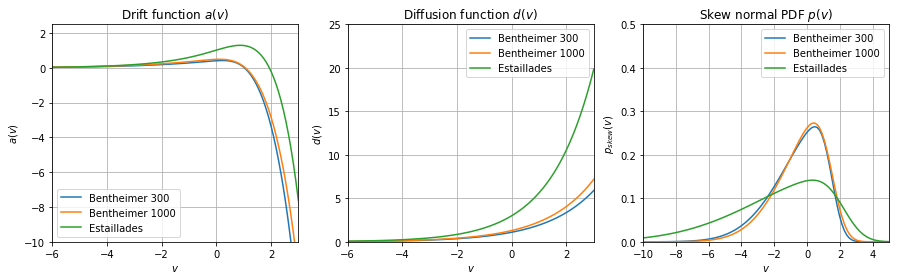

In [3]:
samples = [Bentheimer300, Bentheimer1000, Estaillades]
nv=100
(v_min, v_max) = (-6.0, 3.0)
v=np.linspace(v_min,v_max,nv)
dv= (v_max-v_min)/nv
fig, axs = plt.subplots(1,3, figsize= (15,4))

for (i,sample) in zip(range(len(samples)),samples) :
    axs[0].plot(v,a(v,sample),label = sample['name'])
    axs[1].plot(v,d(v,sample),label = sample['name'])
    axs[2].plot(np.linspace(-10,5,nv),p_skew(np.linspace(-10,5,nv),sample),label = sample['name'])

axs[0].set_title(r'Drift function $a(v)$')
axs[0].set_xlabel(r'$v$')
axs[0].set_ylabel(r'$a(v)$')
axs[0].set_xlim((-6,3))
axs[0].set_ylim((-10,2.5))
axs[0].legend()
axs[0].grid(True)

axs[1].set_title(r'Diffusion function $d(v)$')
axs[1].set_xlabel('$v$')
axs[1].set_ylabel(r'$d(v)$')
axs[1].set_xlim((-6,3))
axs[1].set_ylim((0,25))
axs[1].legend()
axs[1].grid(True)

axs[2].set_title(r'Skew normal PDF $p(v)$')
axs[2].set_xlabel('$v$')
axs[2].set_ylabel(r'$p_{skew}(v)$')
axs[2].set_xlim((-10,5))
axs[2].set_ylim((0,0.5))
axs[2].legend()
axs[2].grid(True)

### Running process and example

In [4]:
samples = [Bentheimer300, Estaillades]
Nmp     = 5
v0      = 1.0
dt      = 0.05
Tmax    = 300.0
Nt      = int(Tmax/dt)+1
csf     = 5
timerange = np.linspace(0,Nt*dt,int(Nt/csf))
DWM_vm  = {}
#for sample in samples :
#    DWM_vm[sample['name']]  = np.array([DWM_process(sample, v0, dt, Nt, csf) for i in range(Nmp)])

for sample in samples :
    DWM_vm[sample['name']]  = Parallel(n_jobs=8)(
        delayed(DWM_process)
        (sample, v0, dt, Nt, csf) for i in range(Nmp))

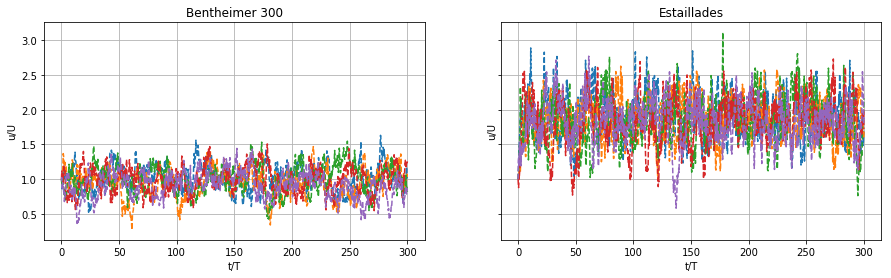

In [5]:
fig, axs = plt.subplots(1,2, sharey = True, figsize=(15,4))
for (i,sample) in zip(range(len(samples)),samples) :
    for n in range(Nmp) :
        axs[i].plot(timerange, DWM_vm[sample['name']][n],'--')
        axs[i].grid(True);
        axs[i].set_ylabel('u/U');
        axs[i].set_xlabel('t/T');
        axs[i].set_title(sample['name']);

### Process Statistics and PDF comparison

In [6]:
samples = [Bentheimer300, Estaillades]
Nmp     = 100
v0      = 1.0
dt      = 0.05
Tmax    = 150.0
Nt      = int(Tmax/dt)+1
csf     = 5.0
MP_lvm  = {}
#for sample in samples :
#    MP_lvm[sample['name']]  = np.array([DWM_process(Bentheimer300, v0, dt, Nt, csf) for i in range(Nmp)])
#    print(np.shape(MP_lvm[sample['name']]))
for sample in samples :
    MP_lvm[sample['name']]  = np.array(Parallel(n_jobs=8)(
        delayed(DWM_process)
        (sample, v0, dt, Nt, csf) for i in range(Nmp)))
    MP_lvm[sample['name']]=MP_lvm[sample['name']].reshape(int(Nt/csf)*Nmp)

In [7]:
print(np.shape(MP_lvm[Bentheimer300['name']]))


(60000,)


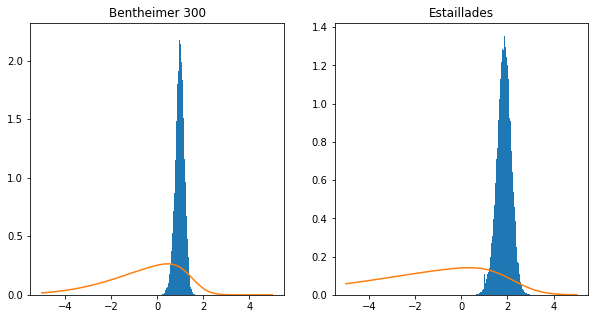

In [8]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
NBINS = 100
#for i in range(1,int(Nt/csf)) :
#    vpdf=plt.hist(MP_lvm[:,i], bins = 10, density = True, alpha = 0.3)
for (i,sample) in zip(range(len(samples)),samples) :
    axs[i].hist(MP_lvm[sample['name']], bins = NBINS, density = True, log = False)
    v = np.linspace(-5,5,100)
    axs[i].plot(v,p_skew(v,sample),label = str(sample));
    axs[i].set_title(sample['name'])

## Loading DNS data

In [9]:
#filename = '../data/Bentheimer300/sl_out_M0_DM0.0E-9_SLSM200_TMAX0.0E2_CSF1.dat'
filename = '../data/Bentheimer300/streamlines.txt'

#dataDNS = np.loadtxt(filename,skiprows=1)

with open(filename, 'r') as f:
    lines = (line for line in f if len(line)>10)
    dataDNS = np.genfromtxt(lines)
dDNS = 3
tDNS=dataDNS[:,0]
NtDNS=len(tDNS)
print('NtDNS = '+str(NtDNS))
uxDNS = dataDNS[:,4]
uyDNS = dataDNS[:,5]
uzDNS = dataDNS[:,6]

NtDNS = 127151


In [21]:
#Computing Umean
N    = 300
ux   = np.zeros((N,N,N))
ux   = np.loadtxt('../data/Bentheimer300/Ux.dat')
UDNS = ux.mean()
print('Ue_x mean = '+str(UDNS)+', Up_xmean = '+str(uxDNS.mean()))

Ue_x mean = 3.918195014621102e-06, Up_xmean = 5.9933506837082303e-05


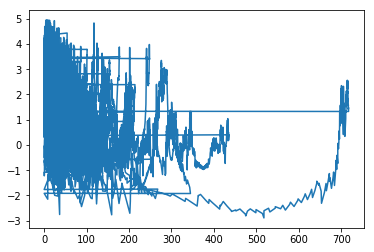

In [11]:
vDNS = np.log(np.sqrt(uxDNS**2+uyDNS**2+uzDNS**2)/UDNS)
plt.plot(tDNS,vDNS)

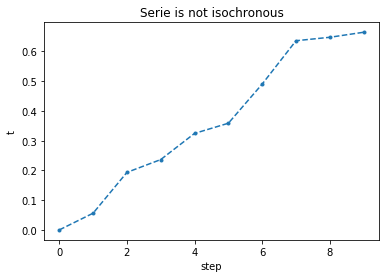

In [12]:
fig, ax = plt.subplots(1,1)
ax.plot(tDNS[range(10)],'.--');
ax.set_xlabel('step');
ax.set_ylabel('t');
ax.set_title('Serie is not isochronous');

#### Making DNS data isochronous

In [13]:
#pointwise linear interpolation
def lin_interp(v1,t1,v0,t0,t) :
    v = v0 + (v1-v0) * (t-t0)/(t1-t0)
    return v

#full isochronous transformation of time serie v(t) for time step dt
def sequ_isochronous_transform(t_serie, v_serie, dt) :
    T_end    = t_serie[-1]
    Nt_iso   = int(T_end/dt)-1
    v_iso    = np.zeros(Nt_iso)
    v_iso[0] = v_serie[0]
    for i in range(1,Nt_iso) :
        t  = i*dt
        m  = 0
        t1 = -1
        while(t1 <= t) :
            m += 1;
            t1 = t_serie[m]
        v1 = v_serie[m]
        t0 = t_serie[m-1]
        v0 = v_serie[m-1]
        v  = lin_interp(v1,t1,v0,t0,t)
        v_iso[i] = v
    return v_iso

def isochronous_transform_process(t_serie, v_serie, dt, i) :
    t_i  = i*dt
    m  = 0
    t1 = -1
    while(t1 <= t_i) :
        m += 1;
        t1 = t_serie[m]
    v1 = v_serie[m]
    t0 = t_serie[m-1]
    v0 = v_serie[m-1]
    v_i  = lin_interp(v1,t1,v0,t0,t_i)
    return v_i

def parallel_isochronous_transform(ncores, t_serie, v_serie, dt) :
    T_end    = t_serie[-1]
    Nt_iso   = int(T_end/dt)-1
    v_iso    = Parallel(n_jobs=8)(
        delayed(isochronous_transform_process)
        (t_serie, v_serie, dt, i) for i in range(Nt_iso))
    return v_iso

In [14]:
#Selecting a bit less points for sake of ressource sparing
Npoints = 20000
#Npoints = NtDNS
#dt array from DNS
dtDNS = [t1-t0 for (t1,t0) in zip(tDNS[range(1,Npoints)],tDNS[range(Npoints-1)])]
dtDNS_ssl = np.array([t1-t0 for (t1,t0) in zip(tDNS[range(1,Npoints)],tDNS[range(Npoints-1)]) if t1 > t0])
#single s.l. DNS data
tDNS_ssl = np.zeros(len(dtDNS_ssl))
T = 0
for i in range(len(dtDNS_ssl)) :
    tDNS_ssl[i] = T
    T += dtDNS_ssl[i]
print(np.shape(tDNS_ssl))
vDNS_ssl = np.array([v for (v,dt) in zip(vDNS,dtDNS) if dt > 0])
print(np.shape(vDNS_ssl))
# Minimal time step :
dt_min = min(dtDNS_ssl)
dt_mean = np.mean(dtDNS_ssl)
print (dt_min)
print (dt_mean)
#plt.plot(tDNS_ssl[range(200)], vDNS_ssl[range(200)],'--.');
#plt.plot(dtDNS_ssl[range(100)],'--.')
dt_iso = 0.05
v_iso  = parallel_isochronous_transform(6, tDNS_ssl, vDNS_ssl, dt_iso)
Nt_iso = len(v_iso)
t_iso  = np.linspace(0,dt_iso*Nt_iso,Nt_iso)

(19968,)
(19968,)
2.8699999994330483e-06
0.0826031262870593


In [15]:
start = time.time()
dt_iso_01 = 0.1
v_iso_01  = parallel_isochronous_transform(6, tDNS_ssl, vDNS_ssl, dt_iso_01)
Nt_iso_01 = len(v_iso_01)
t_iso_01  = np.linspace(0,dt_iso_01*Nt_iso_01,Nt_iso_01)
end = time.time()
print(end-start)

11.266920804977417


In [16]:
dt_iso_1 = 1.0
v_iso_1  = parallel_isochronous_transform(6, tDNS_ssl, vDNS_ssl, dt_iso_1)
Nt_iso_1 = len(v_iso_1)
t_iso_1  = np.linspace(0,dt_iso_1*Nt_iso_1,Nt_iso_1)

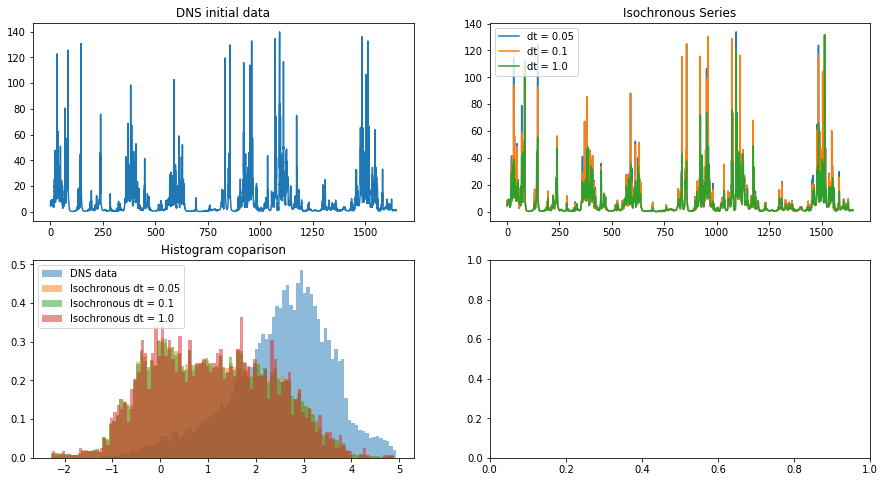

In [20]:
fig, axs = plt.subplots(2,2, figsize=(15,8));
axs[0,0].set_title('DNS initial data');
axs[0,0].plot(tDNS_ssl, np.exp(vDNS_ssl));

axs[0,1].set_title('Isochronous Series');
axs[0,1].plot(t_iso,    np.exp(v_iso),    label='dt = 0.05');
axs[0,1].plot(t_iso_01, np.exp(v_iso_01), label='dt = 0.1');
axs[0,1].plot(t_iso_1,  np.exp(v_iso_1),  label='dt = 1.0');
axs[0,1].legend();

axs[1,0].set_title('Histogram coparison');
axs[1,0].hist(vDNS_ssl, bins = 100, label = 'DNS data',              density = True, alpha= 0.5);
axs[1,0].hist(v_iso,    bins = 100, label = 'Isochronous dt = 0.05', density = True, alpha= 0.5);
axs[1,0].hist(v_iso_01, bins = 100, label = 'Isochronous dt = 0.1',  density = True, alpha= 0.5);
axs[1,0].hist(v_iso_1,  bins = 100, label = 'Isochronous dt = 1.0',  density = True, alpha= 0.5);
axs[1,0].legend();
#plt.plot(t_iso_01,np.exp(v_iso_01));

## Comparing DNS data with Markov model and PDF

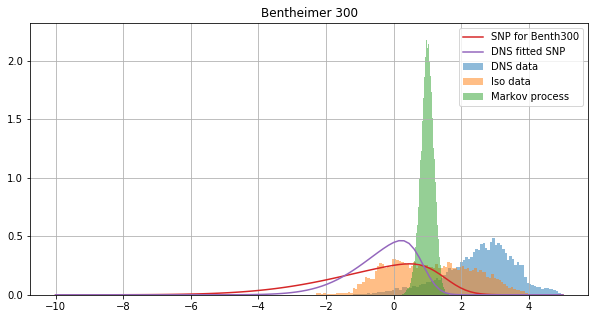

In [18]:
model ={
'name'  : 'Model',
'alpha' : -4.,
'mu'    :  0.85,
'sigma' :  1.5
}
fig, ax = plt.subplots(1,1,figsize=(10,5))
sample = Bentheimer300
data1 = vDNS_ssl
data2 = v_iso
data3 = MP_lvm[sample['name']]

ax.hist(data1, bins = 100, label = 'DNS data',       density = True, alpha= 0.5)
ax.hist(data2, bins = 100, label = 'Iso data',       density = True, alpha= 0.5)
ax.hist(data3, bins = 100, label = 'Markov process', density = True, alpha= 0.5)
v = np.linspace(-10,5,100)
ax.plot(v, p_skew(v,sample), label = 'SNP for Benth300');
ax.plot(v, p_skew(v,model),  label = 'DNS fitted SNP');
ax.grid(True)
ax.set_title(sample['name'])
ax.legend()
del data1, data2, data3